The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [1]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from homegrad.nn import Module
from homegrad.nn import Neuron
from homegrad.nn import Layer
from homegrad.nn import MLPerceptron

from homegrad.engine import * 
from homegrad.drawer import * 

%matplotlib inline

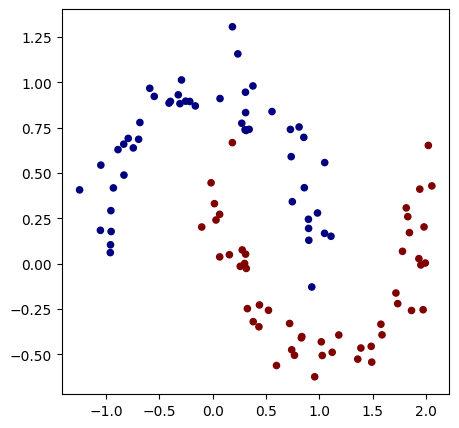

In [2]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 100, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [3]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(100, 2)


In [4]:
#creating an instance of our homemade MLP class with 2 input neurons, a layer with 5 neurons, and another layer with 3 neurons, with 1 output neuron
#n = MLPerceptron(2,[16,16,1])


In [5]:
#for k in range(20):
#    #Forward pass
#    ypred = [n(x) for x in X]
#    loss = sum(((yout - ygt)**2 for ygt,yout in zip(y,ypred)),Value(0))
#    #Now we do the backward pass
#    for p in n.parameters():
#        p.grad = 0.0
#    loss.backward()

#    #Update. now we do gradient descent
#    ##Changing the data of each of our parameters depending on the gradient they have on the loss function. Gradient descent! 
#    for p in n.parameters():
#        p.data += -0.05 * p.grad
#    print(k,loss.data) 

In [6]:
##Ok this absolutely did not work. Let's try this again, but actually think about it this time. First of all, we should be doing batching. 
#Second of all, using MSE for this is a bit silly. Let's try hinge loss. 

#print(MLPerceptron.__init__.__code__.co_varnames)
n = MLPerceptron(2,[16,32,16,1], activations = ['relu', 'relu', 'relu'])
print(n)



MLP of [Layer of [ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2)], Layer of [ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16), ReLu Neuron(16)], Layer of [ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Neuron(32), ReLu Ne

In [7]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    #print("Losses:")
    #for loss in losses:
        #print(f"Loss data: {loss.data}, Loss grad: {loss.grad}, Loss op: {loss._op}")
    
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss(32)
print(total_loss, acc)

Value(data=2.233879828176452, grad=0) 0.34375


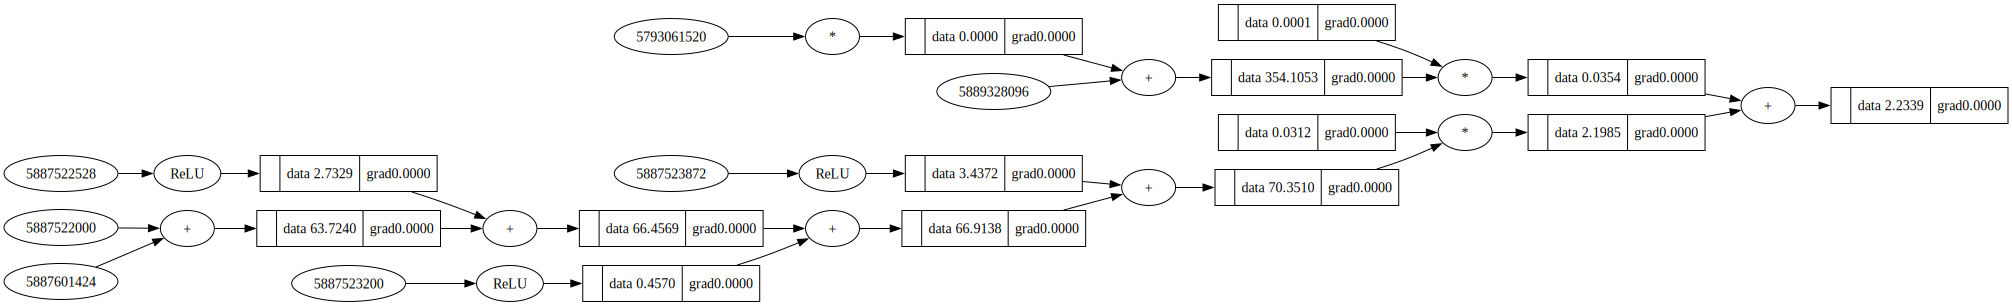

In [8]:
draw_dot(total_loss)

In [9]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss(32)
    
    # backward
    n.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in n.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

final_loss, final_acc = loss()
print(f"Final Loss: {final_loss.data:.4f}, Final Accuracy: {final_acc*100:.2f}%")

step 0 loss 1.6079760022483176, accuracy 53.125%
step 1 loss 1.839969624977218, accuracy 46.875%
step 2 loss 1.7702297090206707, accuracy 53.125%
step 3 loss 2.057267045984368, accuracy 37.5%
step 4 loss 1.7852525048062808, accuracy 43.75%
step 5 loss 1.3377792720492416, accuracy 65.625%
step 6 loss 1.7385786994073658, accuracy 50.0%
step 7 loss 1.728992967998786, accuracy 53.125%
step 8 loss 1.729752119297805, accuracy 46.875%
step 9 loss 1.4441996462807152, accuracy 56.25%
step 10 loss 1.5879270102153797, accuracy 56.25%
step 11 loss 1.7495387130242583, accuracy 43.75%
step 12 loss 1.632553087062296, accuracy 46.875%
step 13 loss 1.8481478575586032, accuracy 46.875%
step 14 loss 1.579271228535401, accuracy 50.0%
step 15 loss 1.1484651458036808, accuracy 65.625%
step 16 loss 1.3824694036774856, accuracy 62.5%
step 17 loss 1.2618676831533135, accuracy 62.5%
step 18 loss 1.3016837780337733, accuracy 59.375%
step 19 loss 1.6590492889042934, accuracy 50.0%
step 20 loss 1.7314005472801728,

(-1.6235846813704597, 2.1264153186295403)

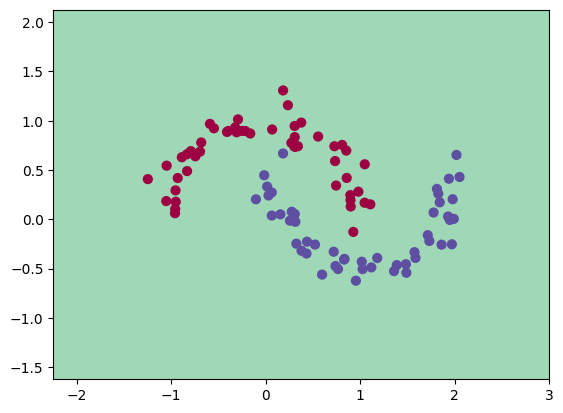

In [10]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())